In [1]:
from copy import deepcopy as copy
import datetime
import json
from math import ceil
import multiprocessing
import logging
import operator
import os
import random
import sys
import time
import typing
import warnings

import geopandas as gpd
import joblib
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy.core.numeric import outer
import pandas as pd
from scipy.stats import mode, entropy
import seaborn as sns
import sklearn.feature_selection
import sklearn.metrics
from sklearn.metrics import roc_auc_score
import sklearn.model_selection
import typer
from tqdm.auto import tqdm

import src

# Preprocessing of port calls data

In [2]:
inspections = (
    pd.read_csv("data/raw/inspections.csv", engine='python', index_col=0, skipfooter=1, parse_dates=['DateOfFirstVisit', 'ShipKeelLayingDate'], dtype={'WasDetained': bool})
    .sort_values('DateOfFirstVisit')
)

with open('data/raw/parismou_performancelist.json') as file:
    performance_list = json.load(file)

portcalls = (
    pd.read_csv('data/raw/portcalls_new.csv', sep=';', low_memory=False, index_col=0)
    .rename(
        columns={
            'ATA_LT': 'arrival',
            'ATD_LT': 'departure',
            'Port.Location.Name': 'port',
            'IMO.Number': 'ship',
            'X.ATA..Ship.Risk.Profile': 'risk',
            'X.ATA..Ship.Flag.Code': 'flag',
            'X.ATA..Ship.Keel.Laying.Date': 'keel_laying',
            'X.ATA..Ship.Type.Description': 'type',
            'X.ATA..Ship.Type.Is.High.Risk': 'type_high_risk',
            'X.ATA..Ship.Flag.Is.PMOU': 'flag_in_pmou',
            'X.ATA..Ship.Priority': 'priority'
        }
    )
    .astype({'port': str, 'ship': str})
    .assign(
        arrival=lambda x: pd.to_datetime(x['arrival']),
        departure=lambda x: pd.to_datetime(x['departure']),
        flag_code=lambda x: x['flag'],
        flag=lambda x: x['flag'].replace(performance_list) != False,
        keel_laying=lambda x: pd.to_datetime(x['keel_laying']),
    )
    .replace({'risk': {'HRS': 2, 'SRS': 1, 'LRS': 0}})
    .sort_values('arrival')
    [[
        'arrival', 'departure', 'port', 'ship', 'risk', 'flag', 
        'keel_laying', 'type', 'type_high_risk', 'flag_in_pmou', 'flag_code',
        'Sent.At', 'priority'
    ]]
)

ships, counts = np.unique(portcalls['ship'], return_counts=True)

portcalls = portcalls.loc[lambda x: x['ship'].isin(set(ships[counts >= 2]))]

## Missing risk
Some port calls miss an entry for the risk. 
Virtually all portcalls with a missing risk, have priority PI.
This priority is commonly associated with risk 1 and hence we categorize all these portcalls with risk 1.

In [3]:
portcalls['risk'].isna().value_counts()

False    4921617
True      467978
Name: risk, dtype: int64

In [4]:
portcalls.groupby(['priority'])['risk'].value_counts(normalize=True).sort_index()

priority     risk
No priority  0.0     0.236096
             1.0     0.737609
             2.0     0.026295
PI           0.0     0.004846
             1.0     0.948614
             2.0     0.046540
PII          0.0     0.146697
             1.0     0.796522
             2.0     0.056781
Name: risk, dtype: float64

In [5]:
portcalls[portcalls['risk'].isna()]['priority'].value_counts()

PI             377540
No priority        57
PII                 1
Name: priority, dtype: int64

In [6]:
portcalls['risk'] = portcalls['risk'].fillna(1)

## Filter on dates

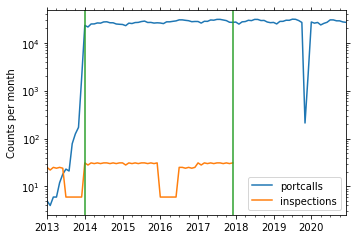

In [7]:
fig, ax = plt.subplots(figsize=(4.82,3.21), constrained_layout=True)
portcalls['arrival'].value_counts().resample('M').size().plot(label='portcalls', ax=ax)
inspections['DateOfFirstVisit'].value_counts().resample('M').size().plot(label='inspections', ax=ax)

start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2017, 12, 1)

ax.axvline(start_date, 0, 10_000, color='C2')
ax.axvline(end_date, 0, 10_000, color='C2')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.set_ylabel('Counts per month')
ax.set_yscale('log')
ax.legend(loc='lower right')
fig.savefig("fig/date-selection.pdf")

# Stats

In [8]:
inspections = src.get_inspections()
portcalls = src.get_portcalls()

first_inspection = inspections.groupby('IMO')['DateOfFirstVisit'].first().to_dict()

result = dict()
ship_not_inspected = list()

for ship, group in tqdm(portcalls.groupby('ship')):
    if ship in first_inspection:
        result[ship] = (group['arrival'] < first_inspection[ship]).sum()
    else:
        ship_not_inspected.append(ship)

{
    'number of portcalls': len(portcalls),
    'number of ships': portcalls.ship.nunique(),
    'number of ships without any portcalls': len(set(inspections['IMO'].unique()) - set(portcalls['ship'].unique())),
    'number of ships not inspected': len(ship_not_inspected),
    'fraction of ships not inspected': len(ship_not_inspected) / portcalls.ship.nunique(),
}

  0%|          | 0/28416 [00:00<?, ?it/s]

{'number of portcalls': 3097752,
 'number of ships': 28416,
 'number of ships without any portcalls': 1761,
 'number of ships not inspected': 6023,
 'fraction of ships not inspected': 0.2119580518018018}

## Number of portcalls before inspection

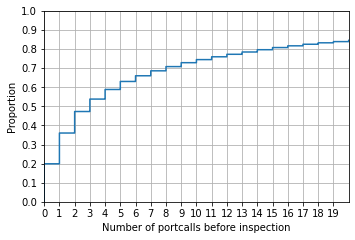

In [9]:
fig, ax = plt.subplots(figsize=(4.82,3.21), constrained_layout=True)
sns.ecdfplot(list(result.values()), stat='proportion', ax=ax)
ax.set_xlim(0, 20)
ax.set_xticks(range(20))
ax.set_yticks(np.linspace(0, 1, 11))
ax.grid()
ax.set_xlabel('Number of portcalls before inspection')
fig.savefig("fig/portcalls-before-selection.pdf")

## Some ships with many portcalls

In [10]:
pd.Series(result).sort_values().tail(10)

9007128     1429
9135262     1521
7351082     1605
8518546     1822
8916126     2033
9151539     2071
9144421     2308
9237644     5265
9170183     6693
9151541    13474
dtype: int64

## Age of ship

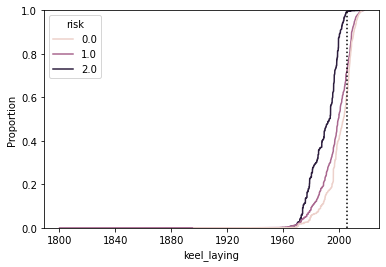

In [11]:
fig, ax = plt.subplots()

sns.ecdfplot(data=portcalls, x='keel_laying', hue='risk', ax=ax)
ax.axvline(portcalls['keel_laying'].max() - pd.DateOffset(years=12), c='black', ls=':')

## Type of ship

In [12]:
(
    portcalls[['type', 'type_high_risk']]
    .drop_duplicates()
    .sort_values('type')
)

,type,type_high_risk
3184584,Bulk carrier,True
1144973,Chemical tanker,True
2085314,Combination carrier,True
11727,Commercial yacht,False
3876918,Container,False
710355,Dredger,False
778644,Fish factory,False
1404794,Fishing vessel,False
2331565,Gas carrier,True
1396760,General cargo/multipurpose,False


## Flag

In [13]:
with pd.option_context('display.max_rows', 200):
    display(
        portcalls[['flag_in_pmou', 'flag_code']]
        .drop_duplicates()
        .sort_values('flag_code')
    )

,flag_in_pmou,flag_code
3708191,False,AE
1630768,False,AG
442437,False,AL
15584,False,AR
1215372,False,AT
374038,False,AU
1466162,False,AZ
476951,False,BB
2076834,False,BD
1302944,True,BE


In [14]:
portcalls['flag_in_pmou'].value_counts(normalize=True)

True     0.697849
False    0.302151
Name: flag_in_pmou, dtype: float64

In [15]:
portcalls['flag'].value_counts(normalize=True)

False    0.966121
True     0.033879
Name: flag, dtype: float64

In [16]:
portcalls['risk'].value_counts().sort_index()

0.0     608985
1.0    2409598
2.0      79169
Name: risk, dtype: int64

In [17]:
(
    portcalls[['flag_in_pmou', 'risk']]
    .value_counts()
    .sort_index()
    .reset_index()
    .pivot(['flag_in_pmou'], ['risk'], 0)
    .apply(lambda x: x/ x.sum(), axis='columns')
)

risk,0.0,1.0,2.0
flag_in_pmou,,,
False,0.163083,0.800071,0.036846
True,0.211097,0.768234,0.020669


## Country of port

In [18]:
iso3166alpha2 = portcalls['port'].str[:2].unique()

In [19]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [20]:
iso3166 = pd.read_csv(
    "https://gist.github.com/tadast/8827699/raw/f5cac3d42d16b78348610fc4ec301e9234f82821/countries_codes_and_coordinates.csv",
).apply(lambda x: x.str.replace('"', "").str.strip())

mask = iso3166.set_index('Alpha-2 code')['Alpha-3 code'].to_dict()

In [21]:
iso3166alpha3 = [mask[country] for country in portcalls['port'].str[:2].unique()]

<AxesSubplot:>

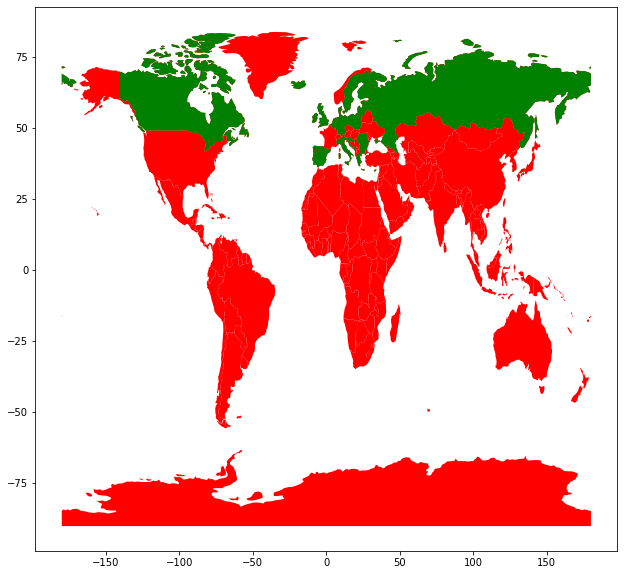

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
world.plot(ax=ax, color='red')
world.loc[lambda x: x.iso_a3.isin(iso3166alpha3)].plot(color='green', ax=ax)

## Sent At

In [23]:
portcalls['Sent.At'].agg(['min', 'max'])

min    2011-10-05 13:37:58
max    2018-05-24 17:30:42
Name: Sent.At, dtype: object